# Library

In [2]:
#image library
import cv2 as cv
import imageio
import matplotlib.pyplot as plt
import matplotlib
from skimage import color
from skimage.filters import threshold_otsu

#standard library
import os
import pickle
import numpy as np
import pandas as pd

#deep learning library
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

#machine learning library
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score

#load model and all support function
from scr.acc_util import Recall, Precision, F1_score
from scr.acc_ass import accuracy_assessment
from scr.net_util import weight_binary_cross_entropy
from scr.seg_model.MyModel.SiameseInception_Keras import SiameseInception

# Read the data

In [14]:
def read_train_data():
    path = os.path.join(DATA_PATH, DATA_SET_NAME,"train")
    train_img_1 = []
    train_img_2 = []
    train_label = []
    file_names = sorted(os.listdir(path))
    for file_name in file_names:
        if file_name[-4:].upper() == '.BMP':
            img = cv.imread(os.path.join(path, file_name))
            if img.shape[0] > img.shape[1]:
                img = img[0:784, :, :]
            elif img.shape[0] < img.shape[1]:
                img = img[:, 0:784, :]
            if 'gt.bmp' in file_name.lower():
                img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
                train_label.append(img)
            elif 'im1.bmp' in file_name.lower():
                train_img_1.append(img)
            elif 'im2.bmp' in file_name.lower():
                train_img_2.append(img)
    with open(os.path.join(DATA_PATH, DATA_SET_NAME,'train_sample_1.pickle'), 'wb') as file:
        pickle.dump(train_img_1, file)
    with open(os.path.join(DATA_PATH, DATA_SET_NAME,'train_sample_2.pickle'), 'wb') as file:
        pickle.dump(train_img_2, file)
    with open(os.path.join(DATA_PATH, DATA_SET_NAME,'train_label.pickle'), 'wb') as file:
        pickle.dump(train_label, file)
    # return train_img_1, train_img_2, train_label

In [15]:
def read_valid_data():
    path = os.path.join(DATA_PATH, DATA_SET_NAME,"valid")
    valid_img_1 = []
    valid_img_2 = []
    valid_label = []
    file_names = sorted(os.listdir(path))
    for file_name in file_names:
        if file_name[-4:].upper() == '.BMP':
            img = cv.imread(os.path.join(path, file_name))
            if img.shape[0] > img.shape[1]:
                img = img[0:784, :, :]
            elif img.shape[0] < img.shape[1]:
                img = img[:, 0:784, :]
            if 'gt.bmp' in file_name.lower():
                img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
                valid_label.append(img)
            elif 'im1.bmp' in file_name.lower():
                valid_img_1.append(img)
            elif 'im2.bmp' in file_name.lower():
                valid_img_2.append(img)
    with open(os.path.join(DATA_PATH, DATA_SET_NAME,'valid_sample_1.pickle'), 'wb') as file:
        pickle.dump(valid_img_1, file)
    with open(os.path.join(DATA_PATH, DATA_SET_NAME,'valid_sample_2.pickle'), 'wb') as file:
        pickle.dump(valid_img_2, file)
    with open(os.path.join(DATA_PATH, DATA_SET_NAME,'valid_label.pickle'), 'wb') as file:
        pickle.dump(valid_label, file)
    # return train_img_1, train_img_2, train_label

In [16]:
def read_test_data():
    path = os.path.join(DATA_PATH, DATA_SET_NAME,"test")
    test_img_1 = []
    test_img_2 = []
    test_label = []
    file_names = sorted(os.listdir(path))
    for file_name in file_names:
        if file_name[-4:].upper() == '.BMP':
            img = cv.imread(os.path.join(path, file_name))
            if img.shape[0] > img.shape[1]:
                img = img[0:784, :, :]
            elif img.shape[0] < img.shape[1]:
                img = img[:, 0:784, :]
            if 'gt.bmp' in file_name.lower():
                img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
                test_label.append(img)
            elif 'im1.bmp' in file_name.lower():
                test_img_1.append(img)
            elif 'im2.bmp' in file_name.lower():
                test_img_2.append(img)
    with open(os.path.join(DATA_PATH, DATA_SET_NAME,'test_sample_1.pickle'), 'wb') as file:
        pickle.dump(test_img_1, file)
    with open(os.path.join(DATA_PATH, DATA_SET_NAME,'test_sample_2.pickle'), 'wb') as file:
        pickle.dump(test_img_2, file)
    with open(os.path.join(DATA_PATH, DATA_SET_NAME,'test_label.pickle'), 'wb') as file:
        pickle.dump(test_label, file)
    # return train_img_1, train_img_2, train_label

# Load the data after read it

In [17]:
def load_train_data(path):
    with open(os.path.join(path, 'train_sample_1.pickle'), 'rb') as file:
        train_X = pickle.load(file)
    with open(os.path.join(path, 'train_sample_2.pickle'), 'rb') as file:
        train_Y = pickle.load(file)
    with open(os.path.join(path, 'train_label.pickle'), 'rb') as file:
        train_label = pickle.load(file)

    return train_X, train_Y, train_label

In [18]:
def load_valid_data(path):
    with open(os.path.join(path, 'valid_sample_1.pickle'), 'rb') as file:
        valid_X = pickle.load(file)
    with open(os.path.join(path, 'valid_sample_2.pickle'), 'rb') as file:
        valid_Y = pickle.load(file)
    with open(os.path.join(path, 'valid_label.pickle'), 'rb') as file:
        valid_label = pickle.load(file)
    return valid_X, valid_Y, valid_label

In [19]:
def load_test_data(path):
    with open(os.path.join(path, 'test_sample_1.pickle'), 'rb') as file:
        test_X = pickle.load(file)
    with open(os.path.join(path, 'test_sample_2.pickle'), 'rb') as file:
        test_Y = pickle.load(file)
    with open(os.path.join(path, 'test_label.pickle'), 'rb') as file:
        test_label = pickle.load(file)
    return test_X, test_Y, test_label

In [20]:
def get_data():
    path = os.path.join(DATA_PATH, DATA_SET_NAME)
    train_X, train_Y, train_label = load_train_data(path=path)
    valid_X, valid_Y, valid_label = load_valid_data(path=path)
    test_X, test_Y, test_label = load_test_data(path=path)

    valid_X = np.array(valid_X) / 255.
    valid_Y = np.array(valid_Y) / 255.
    valid_label = np.array(valid_label) / 255.
    valid_label = np.reshape(valid_label, (valid_label.shape[0], valid_label.shape[1], valid_label.shape[2]))
    
    test_X = np.array(test_X) / 255.
    test_Y = np.array(test_Y) / 255.
    test_label = np.array(test_label) / 255.
    test_label = np.reshape(test_label, (test_label.shape[0], test_label.shape[1], test_label.shape[2]))
    
    for i in range(len(train_X)):
        train_X[i] = train_X[i] / 255.
        train_Y[i] = train_Y[i] / 255.
        train_label[i] = train_label[i] / 255.

    return train_X, train_Y, train_label, valid_X, valid_Y, valid_label,test_X,test_Y,test_label

# Training model

In [21]:
def train_model():
    # get the path
    result_path = os.path.join(RESULT_SAVE_PATH, DATA_SET_NAME)
    model_save_path = os.path.join(MODEL_SAVE_PATH, DATA_SET_NAME)
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    # split into training, valid data
    train_X, train_Y, train_label, valid_X, valid_Y, valid_label,test_X,test_Y,test_label = get_data()
    # load model
    si_model = SiameseInception()
    deep_model = si_model.get_model(input_size=[None, None, 3])
    opt = Adam(lr=LEARNING_RATE)
    
    # compile model
    deep_model.compile(optimizer=opt,
                       loss=weight_binary_cross_entropy, 
                       metrics=['accuracy', Recall, Precision, F1_score])
    deep_model.summary()

    # Plot Architecture
    plot_model(deep_model, 
           to_file='model_DSMS-FCN.png', 
           show_shapes=True,
           show_layer_names=True)
    
    best_loss = 1000
    best_kappa = 0
    best_F1 = 0
    best_acc = 0
    save_best = True
    iter_on_epoch = len(train_X)

    for _epoch in range(MAX_EPOCH):
        train_loss, train_acc, train_sen, train_spe, train_F1 = 0, 0, 0, 0, 0
        for i in range(iter_on_epoch):
            train_1 = np.reshape(train_X[i], (1, train_X[i].shape[0], train_X[i].shape[1], train_X[i].shape[2]))
            train_2 = np.reshape(train_Y[i], (1, train_Y[i].shape[0], train_Y[i].shape[1], train_Y[i].shape[2]))
            label = np.reshape(train_label[i],(1, train_label[i].shape[0], train_label[i].shape[1]))

            #fit model
            temp_loss, temp_train_acc, temp_train_sen, temp_train_spe, temp_train_F1 = \
                deep_model.train_on_batch(x=[train_1, train_2], 
                                          y=label)
            
            train_loss += temp_loss
            train_acc += temp_train_acc
            train_sen += temp_train_sen
            train_spe += temp_train_spe
            train_F1 += temp_train_F1

        train_loss /= iter_on_epoch
        train_acc /= iter_on_epoch
        train_sen /= iter_on_epoch
        train_spe /= iter_on_epoch
        train_F1 /= iter_on_epoch

        train_info = 'epoch %d, train loss is %.4f,  train sen is %.4f, train spe is %.4f, train F1 is %.4f, ' \
                     'train acc is %.4f' % (_epoch, train_loss, train_sen, train_spe, train_F1, train_acc)
        train_info_rec = '%d,%.4f,%.4f,%.4f,%.4f,%.4f' % (_epoch, train_loss, train_sen, train_spe, train_F1, train_acc)
        print(train_info)

        loss, acc, sen, spe, F1 = deep_model.evaluate(x=[valid_X, valid_Y], y=valid_label, batch_size=1)

        binary_change_map = deep_model.predict([valid_X, valid_Y])
        binary_change_map = np.reshape(binary_change_map, (binary_change_map.shape[1], binary_change_map.shape[2]))
        idx_1 = binary_change_map > 0.5
        idx_2 = binary_change_map <= 0.5
        binary_change_map[idx_1] = 255
        binary_change_map[idx_2] = 0

        conf_mat, overall_acc, kappa = accuracy_assessment(
            gt_changed=np.reshape(255 * valid_label, (valid_label.shape[1], valid_label.shape[2])),
            gt_unchanged=np.reshape(255. - 255 * valid_label, (valid_label.shape[1], valid_label.shape[2])),
            changed_map=binary_change_map)

        valid_info = 'epoch %d, valid loss is %.4f,  valid sen is %.4f, valid spe is %.4f, valid F1 is %.4f, ' \
                    'valid acc is %.4f, valid kappa is %.4f' % (
                        _epoch, loss, sen, spe, F1, overall_acc, kappa)
        valid_info_rec = '%d,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f' % (
                        _epoch, loss, sen, spe, F1, overall_acc, kappa)
        print(valid_info)
        print('confusion matrix is ', conf_mat)

        with open(os.path.join(result_path, 'train_log.csv'), 'a+') as f:
            f.write(train_info_rec + '\n')
        with open(os.path.join(result_path, 'valid_log.csv'), 'a+') as f:
            f.write(valid_info_rec + '\n')
        if best_acc < overall_acc:
            best_acc = overall_acc
            save_best = True
        if loss < best_loss:
            best_loss = loss
            save_best = True
        if kappa > best_kappa:
            best_kappa = kappa
            save_best = True
        if F1 > best_F1:
            best_F1 = F1
            save_best = True
        if save_best:
            cv.imwrite(os.path.join(result_path, str(_epoch) + '_bcm.bmp'), binary_change_map)
            save_best = False
            deep_model.save(os.path.join(model_save_path, str(_epoch) + '_model.h5'))

    best_info = 'best loss is %.4f, best F1 is %.4f, best acc is %.4f, best kappa is %.4f, ' % (
        best_loss, best_F1, best_acc, best_kappa)
    print('train is done, ' + best_info)
    param_info = 'learning rate ' + str(LEARNING_RATE) + ', Max Epoch is ' + str(MAX_EPOCH)
    print('parameter is, ' + param_info)
    with open(os.path.join(result_path, 'log.txt'), 'a+') as f:
        f.write(best_info + '\n')
        f.write(param_info + '\n')

# Run the Program

## Parameter

In [13]:
BATCH_SZ = 512 #or 1
LEARNING_RATE = 2e-4 #or 1e-4
MAX_EPOCH = 100 #or 250
RESULT_SAVE_PATH = 'result/'
MODEL_SAVE_PATH = 'model_param/'
DATA_PATH = './data/'
DATA_SET_NAME = 'Szada_Tisza/'

## run this part

In [22]:
if __name__ == '__main__':
    read_train_data()
    read_valid_data()
    read_test_data()
    train_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
FEM (Model)                     ((None, None, None,  191904      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
up_sampling2d_4 (UpSampling2D)  (None, None, None, 1 0           FEM[2][0]                  

epoch 0, train loss is 0.2018,  train sen is 0.0018, train spe is 0.0565, train F1 is nan, train acc is 0.1101
1/1 [==============================] - 1s 704ms/sample - loss: 0.3234 - accuracy: 0.0134 - Recall: 0.0028 - Precision: 0.2197 - F1_score: 0.0056
epoch 0, valid loss is 0.3234,  valid sen is 0.0028, valid spe is 0.2197, valid F1 is 0.0056, valid acc is 0.9412, valid kappa is 0.0041
confusion matrix is  [[330532    206]
 [ 20436     58]]
epoch 1, train loss is 0.1400,  train sen is 0.0014, train spe is 0.5224, train F1 is nan, train acc is 0.1059
1/1 [==============================] - 0s 75ms/sample - loss: 0.2176 - accuracy: 0.0112 - Recall: 0.0155 - Precision: 0.1555 - F1_score: 0.0282
epoch 1, valid loss is 0.2176,  valid sen is 0.0155, valid spe is 0.1555, valid F1 is 0.0282, valid acc is 0.9376, valid kappa is 0.0178
confusion matrix is  [[329011   1727]
 [ 20176    318]]
epoch 2, train loss is 0.1217,  train sen is 0.0078, train spe is 0.5637, train F1 is nan, train acc is

epoch 18, valid loss is 0.2000,  valid sen is 0.6976, valid spe is 0.3691, valid F1 is 0.4828, valid acc is 0.9128, valid kappa is 0.4400
confusion matrix is  [[306301  24437]
 [  6198  14296]]
epoch 19, train loss is 0.0779,  train sen is 0.4366, train spe is 0.6627, train F1 is 0.4962, train acc is 0.0280
1/1 [==============================] - 0s 78ms/sample - loss: 0.2171 - accuracy: 0.0045 - Recall: 0.7512 - Precision: 0.3365 - F1_score: 0.4648
epoch 19, valid loss is 0.2171,  valid sen is 0.7512, valid spe is 0.3365, valid F1 is 0.4648, valid acc is 0.8990, valid kappa is 0.4178
confusion matrix is  [[300374  30364]
 [  5098  15396]]
epoch 20, train loss is 0.0750,  train sen is 0.4417, train spe is 0.6731, train F1 is 0.5062, train acc is 0.0264
1/1 [==============================] - 0s 80ms/sample - loss: 0.2353 - accuracy: 0.0045 - Recall: 0.8059 - Precision: 0.3111 - F1_score: 0.4489
epoch 20, valid loss is 0.2353,  valid sen is 0.8059, valid spe is 0.3111, valid F1 is 0.4489,

epoch 37, train loss is 0.0554,  train sen is 0.5349, train spe is 0.7489, train F1 is 0.6061, train acc is 0.0175
1/1 [==============================] - 0s 81ms/sample - loss: 0.2356 - accuracy: 0.0112 - Recall: 0.7721 - Precision: 0.3238 - F1_score: 0.4562
epoch 37, valid loss is 0.2356,  valid sen is 0.7721, valid spe is 0.3238, valid F1 is 0.4562, valid acc is 0.8926, valid kappa is 0.4075
confusion matrix is  [[297689  33049]
 [  4670  15824]]
epoch 38, train loss is 0.0539,  train sen is 0.5440, train spe is 0.7523, train F1 is 0.6128, train acc is 0.0180
1/1 [==============================] - 0s 79ms/sample - loss: 0.2075 - accuracy: 0.0045 - Recall: 0.7117 - Precision: 0.3558 - F1_score: 0.4744
epoch 38, valid loss is 0.2075,  valid sen is 0.7117, valid spe is 0.3558, valid F1 is 0.4744, valid acc is 0.9080, valid kappa is 0.4301
confusion matrix is  [[304327  26411]
 [  5908  14586]]
epoch 39, train loss is 0.0524,  train sen is 0.5481, train spe is 0.7541, train F1 is 0.6162,

epoch 55, valid loss is 0.2104,  valid sen is 0.7648, valid spe is 0.3622, valid F1 is 0.4916, valid acc is 0.9077, valid kappa is 0.4479
confusion matrix is  [[303145  27593]
 [  4821  15673]]
epoch 56, train loss is 0.0451,  train sen is 0.6043, train spe is 0.7864, train F1 is 0.6673, train acc is 0.0168
1/1 [==============================] - 0s 78ms/sample - loss: 0.2141 - accuracy: 0.0000e+00 - Recall: 0.7616 - Precision: 0.3586 - F1_score: 0.4876
epoch 56, valid loss is 0.2141,  valid sen is 0.7616, valid spe is 0.3586, valid F1 is 0.4876, valid acc is 0.9066, valid kappa is 0.4435
confusion matrix is  [[302822  27916]
 [  4885  15609]]
epoch 57, train loss is 0.0441,  train sen is 0.6098, train spe is 0.8001, train F1 is 0.6738, train acc is 0.0163
1/1 [==============================] - 0s 81ms/sample - loss: 0.2380 - accuracy: 0.0022 - Recall: 0.7917 - Precision: 0.3325 - F1_score: 0.4683
epoch 57, valid loss is 0.2380,  valid sen is 0.7917, valid spe is 0.3325, valid F1 is 0.4

epoch 74, train loss is 0.0366,  train sen is 0.6734, train spe is 0.8245, train F1 is 0.7309, train acc is 0.0165
1/1 [==============================] - 0s 82ms/sample - loss: 0.3078 - accuracy: 0.0022 - Recall: 0.8797 - Precision: 0.3037 - F1_score: 0.4515
epoch 74, valid loss is 0.3078,  valid sen is 0.8797, valid spe is 0.3037, valid F1 is 0.4515, valid acc is 0.8753, valid kappa is 0.3995
confusion matrix is  [[289410  41328]
 [  2466  18028]]
epoch 75, train loss is 0.0355,  train sen is 0.6893, train spe is 0.8326, train F1 is 0.7472, train acc is 0.0194
1/1 [==============================] - 0s 82ms/sample - loss: 0.2896 - accuracy: 0.0045 - Recall: 0.8611 - Precision: 0.3113 - F1_score: 0.4572
epoch 75, valid loss is 0.2896,  valid sen is 0.8611, valid spe is 0.3113, valid F1 is 0.4572, valid acc is 0.8807, valid kappa is 0.4064
confusion matrix is  [[291686  39052]
 [  2846  17648]]
epoch 76, train loss is 0.0355,  train sen is 0.6854, train spe is 0.8267, train F1 is 0.7420,

epoch 92, valid loss is 0.2049,  valid sen is 0.7530, valid spe is 0.3821, valid F1 is 0.5070, valid acc is 0.9145, valid kappa is 0.4656
confusion matrix is  [[305786  24952]
 [  5063  15431]]
epoch 93, train loss is 0.0381,  train sen is 0.6793, train spe is 0.8274, train F1 is 0.7295, train acc is 0.0212
1/1 [==============================] - 0s 79ms/sample - loss: 0.2259 - accuracy: 0.0089 - Recall: 0.8230 - Precision: 0.3411 - F1_score: 0.4824
epoch 93, valid loss is 0.2259,  valid sen is 0.8230, valid spe is 0.3411, valid F1 is 0.4824, valid acc is 0.8969, valid kappa is 0.4358
confusion matrix is  [[298163  32575]
 [  3627  16867]]
epoch 94, train loss is 0.0352,  train sen is 0.7041, train spe is 0.8261, train F1 is 0.7528, train acc is 0.0184
1/1 [==============================] - 0s 79ms/sample - loss: 0.2212 - accuracy: 0.0022 - Recall: 0.7843 - Precision: 0.3698 - F1_score: 0.5026
epoch 94, valid loss is 0.2212,  valid sen is 0.7843, valid spe is 0.3698, valid F1 is 0.5026,

# Evaluate model

In [25]:
def evaluate():
    path = os.path.join(DATA_PATH, DATA_SET_NAME)
    result_path = os.path.join(RESULT_SAVE_PATH, DATA_SET_NAME)
    train_X, train_Y, train_label, valid_X, valid_Y, valid_label,test_X,test_Y,test_label = get_data()
    
    dsms_fcn = load_model('./model_param/Szada_Tisza/95_model.h5',compile=False)
    dsms_fcn.compile(optimizer=Adam(lr=LEARNING_RATE),
                       loss=weight_binary_cross_entropy, 
                       metrics=['accuracy', Recall, Precision, F1_score])

    loss, acc, sen, spe, F1 = dsms_fcn.evaluate(x=[valid_X, valid_Y], y=valid_label, batch_size=1)
    print("\nTesting Accuracy:  {:.4f}".format(acc))
    print("Testing loss:  {:.4f}".format(loss))
    
    binary_change_map = dsms_fcn.predict([valid_X, valid_Y])
    binary_change_map = np.reshape(binary_change_map, (binary_change_map.shape[1], binary_change_map.shape[2]))
    idx_1 = binary_change_map > 0.5
    idx_2 = binary_change_map <= 0.5
    binary_change_map[idx_1] = 255
    binary_change_map[idx_2] = 0
    
    conf_mat, overall_acc, kappa = accuracy_assessment(
    gt_changed=np.reshape(255 * valid_label, (valid_label.shape[1], valid_label.shape[2])),
    gt_unchanged=np.reshape(255. - 255 * valid_label, (valid_label.shape[1], valid_label.shape[2])),
    changed_map=binary_change_map)

    valid_info = ' valid loss is %.4f,  valid sen is %.4f, valid spe is %.4f, valid F1 is %.4f, ' \
                'valid acc is %.4f, valid kappa is %.4f, ' % (
                   loss, sen, spe, F1, overall_acc, kappa)
    print(valid_info)
    print('confusion matrix is ', conf_mat)
    
    cv.imwrite(os.path.join(result_path, 'valid' + '_bcm.bmp'), binary_change_map)

evaluate()

1/1 [==============================] - 1s 838ms/sample - loss: 0.1946 - accuracy: 0.0045 - Recall: 0.7579 - Precision: 0.3907 - F1_score: 0.5156

Testing Accuracy:  0.0045
Testing loss:  0.1946
 valid loss is 0.1946,  valid sen is 0.7579, valid spe is 0.3907, valid F1 is 0.5156, valid acc is 0.9169, valid kappa is 0.4752, 
confusion matrix is  [[306514  24224]
 [  4961  15533]]


# Testing model

In [26]:
def testing():
    result_path = os.path.join(RESULT_SAVE_PATH, DATA_SET_NAME)
    path = os.path.join(DATA_PATH, DATA_SET_NAME)
    train_X, train_Y, train_label, valid_X, valid_Y, valid_label,test_X,test_Y,test_label = get_data()
    
    dsms_fcn = load_model('./model_param/Szada_Tisza/95_model.h5',compile=False)
    dsms_fcn.compile(optimizer=Adam(lr=LEARNING_RATE),
                       loss=weight_binary_cross_entropy, 
                       metrics=['accuracy', Recall, Precision, F1_score])

    loss, acc, sen, spe, F1 = dsms_fcn.evaluate(x=[test_X, test_Y], y=test_label, batch_size=1)
    print("\nTesting Accuracy:  {:.4f}".format(acc))
    print("Testing loss:  {:.4f}".format(loss))
    
    binary_change_map = dsms_fcn.predict([test_X, test_Y])
    binary_change_map = np.reshape(binary_change_map, (binary_change_map.shape[1], binary_change_map.shape[2]))
    idx_1 = binary_change_map > 0.5
    idx_2 = binary_change_map <= 0.5
    binary_change_map[idx_1] = 255
    binary_change_map[idx_2] = 0
    
    conf_mat, overall_acc, kappa = accuracy_assessment(
    gt_changed=np.reshape(255 * test_label, (test_label.shape[1], test_label.shape[2])),
    gt_unchanged=np.reshape(255. - 255 * test_label, (test_label.shape[1], test_label.shape[2])),
    changed_map=binary_change_map)

    valid_info = 'test loss is %.4f,  test sen is %.4f, test spe is %.4f, test F1 is %.4f, ' \
                'test acc is %.4f, test kappa is %.4f, ' % (
                     loss, sen, spe, F1, overall_acc, kappa)
    print(valid_info)
    print('confusion matrix is ', conf_mat)

    cv.imwrite(os.path.join(result_path, 'testing' + '_bcm.bmp'), binary_change_map)
    
testing()

1/1 [==============================] - 1s 717ms/sample - loss: 0.5413 - accuracy: 0.0379 - Recall: 0.4290 - Precision: 0.7145 - F1_score: 0.5361

Testing Accuracy:  0.0379
Testing loss:  0.5413
valid loss is 0.5413,  valid sen is 0.4290, valid spe is 0.7145, valid F1 is 0.5361, valid acc is 0.8730, valid kappa is 0.4678, 
confusion matrix is  [[280835  10303]
 [ 34315  25779]]


# plot history

In [27]:
result_path = os.path.join(RESULT_SAVE_PATH, DATA_SET_NAME)
res_train = pd.read_csv(os.path.join(result_path, 'train_log.csv'),names=['_epoch', 'train_loss', 'train_sen', 'train_spe', 'train_F1', 'train_acc'],header=0)
res_valid = pd.read_csv(os.path.join(result_path, 'valid_log.csv'),names=['_epoch', 'loss', 'sen', 'spe', 'F1', 'overall_acc', 'kappa'],header=0)

In [28]:
def plot_history(res_train,res_valid):
    acc = res_train['train_acc']
    val_acc = res_valid['overall_acc']
    loss = res_train['train_loss']
    val_loss = res_valid['loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

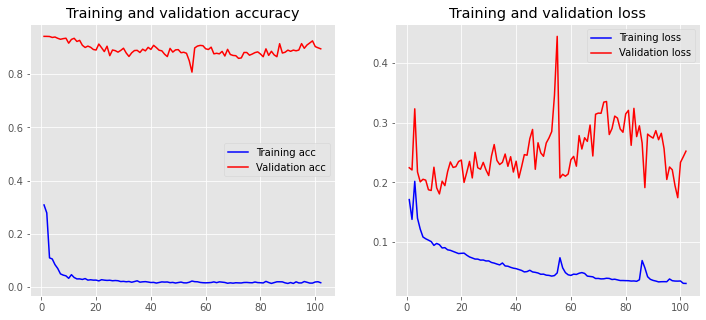

In [29]:
plt.style.use('ggplot')
plot_history(res_train,res_valid)

# Result

In [72]:
path_data = os.path.join(DATA_PATH, DATA_SET_NAME,"valid")
path_res = os.path.join(RESULT_SAVE_PATH, DATA_SET_NAME)
img_1 = cv.imread(os.path.join(path_data, '1_im1.bmp'))
img_2 = cv.imread(os.path.join(path_data, '1_im2.bmp'))
img_gt = cv.imread(os.path.join(path_data, '1_gt.bmp'))
result = cv.imread(os.path.join(path_res, 'valid_bcm.bmp'))

In [73]:
def biner_image(col_true,col_false,img_gt):
    # Threshold image to binary
    img_gt = color.rgb2gray(img_gt)
    thresh = threshold_otsu(img_gt)
    img_gt = img_gt > thresh

    # Make 3 channel RGB image same dimensions
    gt = np.zeros((img_gt.shape[0],img_gt.shape[1],3), dtype=np.uint8)

    # Make True pixels red
    gt[img_gt]  = col_true
    # Make False pixels blue
    gt[~img_gt] = col_false
    return(gt)

In [74]:
def plot_result(img_2,gt,result):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 15),
                          sharex=True, sharey=True,frameon=False)
    axes.set_axis_off()
    plt.imshow(img_2)
    plt.imshow(result,alpha=0.5)
    plt.imshow(gt,alpha=0.5)
    plt.show()

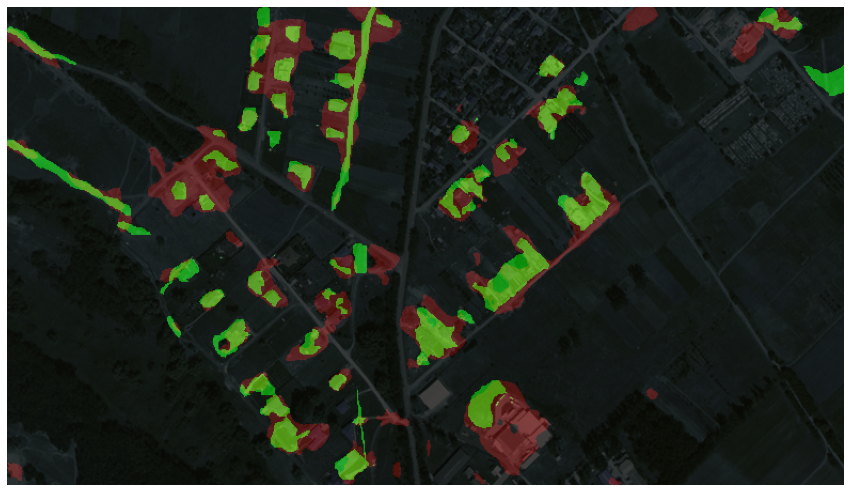

In [75]:
gt = biner_image([0,255,0],[0,0,0],img_gt)
re = biner_image([255,0,0],[0,0,0],result)
plot_result(img_2,gt,re)